In [ ]:
import random
import pylab as plt
import torch
import numpy as np
import torch.nn as nn
import os
import copy
import json

import warnings

from tqdm.auto import tqdm
from sklearn import datasets

import ray
from ray import tune
from ray.tune import Trainable
from ray import air
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB
from ray.tune.search.bohb import TuneBOHB

In [ ]:
def stochasitc_augmentation(X: torch.tensor, noise: float = 1):
    return X + torch.randn_like(X)*noise

In [ ]:
class SSLDataset(torch.utils.data.TensorDataset):
    def __init__(self, data, targets, noise):
        self.tensors = [data, targets]
        self.noise = noise

    def __getitem__(self, idx):
        X, y = [t[idx] for t in self.tensors]
        return [stochasitc_augmentation(X, self.noise), stochasitc_augmentation(X, self.noise)], y
    
    def __len__(self):
        return self.tensors[0].shape[0]

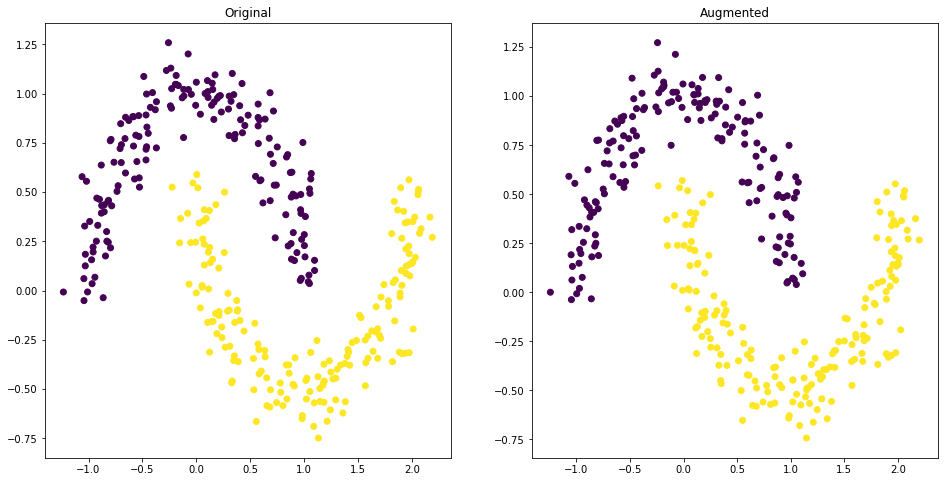

In [ ]:
def build_dataset(n_samples, test_set_size=100, ds_noise=0.05, aug_noise=0.05, seed=42):
    assert n_samples > test_set_size, "Test Set is a sub-sample of n_samples"
    X, y = datasets.make_moons(n_samples, noise=ds_noise, random_state=seed)
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).long()

    random.seed(seed)
    test_indices = random.sample(range(X.shape[0]), k = test_set_size)
    train_indices = [i for i in range(X.shape[0]) if i not in test_indices]
    train_ds = torch.utils.data.TensorDataset(X[train_indices], y[train_indices])
    ssl_ds = SSLDataset(X[train_indices], y[train_indices], noise=aug_noise)
    test_ds = torch.utils.data.TensorDataset(X[test_indices], y[test_indices])
    return train_ds, ssl_ds, test_ds

train_ds, ssl_ds, test_ds = build_dataset(n_samples=450, test_set_size=100, ds_noise=0.1, aug_noise=0.01, seed=42)
fix, ax = plt.subplots(1, 2, figsize=(16,8))
X_aug, y_aug = ssl_ds[range(len(ssl_ds))]
ax[0].scatter(train_ds.tensors[0][:,0], train_ds.tensors[0][:,1], c=train_ds.tensors[1])
ax[0].set_title("Original")
ax[1].scatter(X_aug[0][:,0], X_aug[0][:,1], c=y_aug)
ax[1].set_title("Augmented")
plt.show()

In [ ]:
@torch.no_grad()
def plot_contour(model, X, y, ax=None, feature_extractor=None):
    model.eval()
    model.cpu()
    origin = 'lower'
    if ax:
        plt.sca(ax)
    domain = 3
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51), indexing='ij')
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    if feature_extractor:
        feature_extractor.eval()
        feature_extractor.cpu()
        zz = feature_extractor(zz)
    logits = model(zz)
    probas = logits.softmax(-1)
    zz = probas[:, 1].view(xx.shape)

    plt.scatter(X[:, 0], X[:, 1], c=y, s=15)
    CS = plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6), origin=origin)
    CS2 = plt.contour(CS, levels=[0.5], colors='black', origin=origin)
    cbar = plt.colorbar(CS)
    cbar.add_lines(CS2)

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes: int = 2, feature_dim: int = 128, projection_dim: int = 64):
        super(Net, self).__init__()
        self.base_encoder = nn.Sequential(nn.Linear(2, feature_dim), nn.ReLU())
        self.projector = nn.Sequential(nn.Linear(feature_dim, projection_dim), nn.ReLU())
        self.fc = nn.Linear(feature_dim, num_classes)

    def forward(self, x, get_projections=False, get_features=False):
        if get_projections:
            x = self.base_encoder(x)
            return self.projector(x)
        elif get_features:
            return self.base_encoder(x)
        else:
            with torch.no_grad():
                x = self.base_encoder(x)
            return self.fc(x)

In [ ]:
LARGE_NUM = 1e9

class NTXent(nn.Module):
    def __init__(self, batch_size, hidden_norm: bool = True, temperature: int = 1.0, n_views: int = 2):
        super(NTXent, self).__init__()
        self.sim = nn.CosineSimilarity(dim=-1)
        self.temperature = temperature
        self.hidden_norm = hidden_norm
        self.device='cuda'
        self.ce_loss = torch.nn.CrossEntropyLoss()
        self.batch_size = batch_size
        self.n_views = n_views

    def forward(self, features):
        labels = torch.cat([torch.arange(self.batch_size) for i in range(self.n_views)], dim=0)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
        labels = labels.to(self.device)

        features = nn.functional.normalize(features, dim=1)

        similarity_matrix = torch.matmul(features, features.T)

        # discard the main diagonal from both: labels and similarities matrix
        mask = torch.eye(labels.shape[0], dtype=torch.bool).to(self.device)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)
        assert similarity_matrix.shape == labels.shape

        # select and combine multiple positives
        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)

        # select only the negatives the negatives
        negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)

        logits = torch.cat([positives, negatives], dim=1)
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(self.device)

        logits = logits / self.temperature
        loss = self.ce_loss(logits, labels)

        return loss

In [ ]:
def pretrain_one_epoch(model, optimizer, criterion, unsupervised_loader, device='cuda'):
    model.train()
    model.to(device)
    criterion.to(device)

    total_loss, n_samples = 0, 0

    # Train the epoch
    for data, _ in unsupervised_loader:
        data = torch.cat(data, dim=0)
        data = data.to(device)
        batch_size = data.shape[0]

        # Unsupervised loss
        out = model(data, get_projections=True)
        loss = criterion(out)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_size
        n_samples += batch_size

    return {'loss': total_loss/n_samples}

In [ ]:
def train_one_epoch(model, optimizer, criterion, supervised_loader, device='cuda'):
    model.train()
    model.to(device)
    criterion.to(device)

    total_loss, n_samples, n_correct = 0, 0, 0 

    # Train the epoch
    for (x, y) in supervised_loader:
        x, y = x.to(device), y.to(device)
        batch_size = x.shape[0]

        out = model(x)
        loss = criterion(out, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_size
        n_samples += batch_size
        n_correct += torch.sum(torch.max(out.softmax(-1), dim=-1)[1] == y).item()

    return {
        'loss':total_loss/n_samples, 
        'acc':n_correct/n_samples*100
        }

In [ ]:
@torch.no_grad()
def evaluate(model, criterion, test_loader, device='cuda'):
    model.eval()
    model.to(device)
    criterion.to(device)

    total_loss, n_samples, n_correct = 0, 0, 0 

    # Train the epoch
    for (x, y) in test_loader:
        x, y = x.to(device), y.to(device)
        batch_size = x.shape[0]

        out = model(x)
        loss = criterion(out, y)

        total_loss += loss.item() * batch_size
        n_samples += batch_size
        n_correct += torch.sum(torch.max(out.softmax(-1), dim=-1)[1] == y).item()

    return {
        'loss':total_loss/n_samples, 
        'acc':n_correct/n_samples*100
        }

In [ ]:
class MyTrainableClass(Trainable):
    def setup(self, config):
        self.timestep = 0
        self.unlabeled_ds = build_dataset(n_samples=config['n_samples'], test_set_size=config['test_set_size'], ds_noise=config['ds_noise'], aug_noise=config['aug_noise'], seed=config['random_seed'])[1]
        torch.manual_seed(config['random_seed'])
        self.model = Net(config['n_classes'], config['feature_dim'], config['projection_dim'])
        self.pretrain_optimizer = torch.optim.SGD(self.model.parameters(), lr=config['learning_rate_pretrain'], momentum=0.9, weight_decay=config['weight_decay_pretrain'], nesterov=True)
        self.pretrain_criterion = NTXent(batch_size=config['batch_size_pretrain'], temperature=config['temperature'], hidden_norm=True)
        self.pretrain_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.pretrain_optimizer, T_max=config['n_epochs_pretrain']-config['n_epochs_warmup'])
        self.pretrain_loader = torch.utils.data.DataLoader(self.unlabeled_ds, batch_size=config['batch_size_pretrain'], shuffle=True, drop_last=True)


    def step(self):
        for i in range(self.config['step_size']):
            pretrain_stats = pretrain_one_epoch(self.model, self.pretrain_optimizer, self.pretrain_criterion, self.pretrain_loader)
            if self.timestep > self.config['n_epochs_warmup']:
                self.pretrain_lr_scheduler.step()
        self.timestep += 1
        return {'loss': pretrain_stats['loss']}

    def save_checkpoint(self, checkpoint_dir):
        path = os.path.join(checkpoint_dir, "checkpoint")
        with open(path, "w") as f:
            f.write(json.dumps({"timestep": self.timestep}))
        return path

    def load_checkpoint(self, checkpoint_path):
        with open(checkpoint_path) as f:
            self.timestep = json.loads(f.read())["timestep"]

    @classmethod
    def default_resource_request(cls, config):
        return {"CPU": 2, "GPU":0.5}

In [ ]:
config = {
    "random_seed":42,
    "n_samples":450,
    "test_set_size":150,
    "ds_noise":0.1,
    
    "n_epochs_warmup":10,
    "n_epochs_pretrain":100,
    "learning_rate_pretrain": tune.uniform(1e-4, .1),
    "weight_decay_pretrain": tune.uniform(0, .1),
    "batch_size_pretrain":64,
    "aug_noise":0.01,
    "temperature":1,

    "n_epochs_supervised":100,
    "learning_rate_supervised":1e-1,
    "weight_decay_supervised":5e-4,
    "batch_size_supervised":32,
    "batch_size_test":64,

    "feature_dim": 128,
    "projection_dim": tune.choice(range(129)),
    "n_classes":2,

    "step_size":25,

}

config['n_iterations'] = config['n_epochs_pretrain']//config['step_size']

In [ ]:
seed = config['random_seed']
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [14]:
warnings.filterwarnings("ignore", category=FutureWarning)

if ray.is_initialized():
    ray.shutdown()
ray.init(num_cpus=4, num_gpus=1)

assert config['n_epochs_pretrain']%config['step_size'] == 0, 'n_epochs pretrain should be a multiple of step size'

bohb_search = TuneBOHB()
bohb_search = tune.search.ConcurrencyLimiter(bohb_search, max_concurrent=4)
bohb_hyperband = HyperBandForBOHB(
    time_attr="training_iteration",
    reduction_factor=2,
    stop_last_trials=False,
)

tuner = tune.Tuner(
    MyTrainableClass,
    run_config=air.RunConfig(name="bohb_test", stop={"training_iteration": 5}),
    tune_config=tune.TuneConfig(
        metric="loss",
        mode="min",
        scheduler=bohb_hyperband,
        search_alg=bohb_search,
        num_samples=100,
    ),
    param_space=config,
)
results = tuner.fit()

print("Best hyperparameters found were: ", results.get_best_result().config)
opt_pretrain_config = results.get_best_result().config

2023-05-01 19:46:51,842	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


2023-05-01 19:46:55,912	WARNING trial_runner.py:1543 -- You are trying to access _search_alg interface of TrialRunner in TrialScheduler, which is being restricted. If you believe it is reasonable for your scheduler to access this TrialRunner API, please reach out to Ray team on GitHub. A more strict API access pattern would be enforced starting 1.12s.0


Trial name,date,done,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
MyTrainableClass_139d1ad1,2023-05-01_19-46-59,False,denis-MS-7C37,1,4.84404,141.51.131.177,29052,1.9441,1.9441,1.9441,1682963219,1,139d1ad1
MyTrainableClass_29b0d56c,2023-05-01_19-46-55,False,denis-MS-7C37,1,4.84419,141.51.131.177,28955,2.03686,2.03686,2.03686,1682963215,1,29b0d56c
MyTrainableClass_4af332d7,2023-05-01_19-47-01,False,denis-MS-7C37,1,4.84419,141.51.131.177,29106,2.02276,2.02276,2.02276,1682963221,1,4af332d7
MyTrainableClass_83acdea1,2023-05-01_19-46-57,False,denis-MS-7C37,1,4.686,141.51.131.177,28997,2.00499,2.00499,2.00499,1682963217,1,83acdea1


2023-05-01 19:48:36,358	WARNING tune.py:184 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2023-05-01 19:48:38,104	ERROR tune.py:941 -- Trials did not complete: [MyTrainableClass_29b0d56c, MyTrainableClass_83acdea1, MyTrainableClass_139d1ad1, MyTrainableClass_4af332d7, MyTrainableClass_1a43a903, MyTrainableClass_28743143, MyTrainableClass_6de1308b, MyTrainableClass_9b160e2a, MyTrainableClass_75a96a7a, MyTrainableClass_8552a737, MyTrainableClass_cdec011a, MyTrainableClass_7ed99b70, MyTrainableClass_d83c0d6d, MyTrainableClass_eee47b68, MyTrainableClass_323bf428, MyTrainableClass_286cdbdf, MyTrainableClass_50a63041, MyTrainableClass_e3f8bda6, MyTrainableClass_87aacf1f, MyTrainableClass_49787c59, MyTrainableClass_77dc272f, MyTrainableClass_dfa7a1dd, MyTrainableClass_41dcb5de, MyTrainableClass_33c8b26b, MyTrainableClass_afccb33c, MyTrainableClass_ff

Best hyperparameters found were:  {'random_seed': 42, 'n_samples': 450, 'test_set_size': 150, 'ds_noise': 0.1, 'n_epochs_warmup': 10, 'n_epochs_pretrain': 100, 'learning_rate_pretrain': 0.0011238738906228197, 'weight_decay_pretrain': 0.07543672144596723, 'batch_size_pretrain': 64, 'aug_noise': 0.01, 'temperature': 1, 'n_epochs_supervised': 100, 'learning_rate_supervised': 0.1, 'weight_decay_supervised': 0.0005, 'batch_size_supervised': 32, 'batch_size_test': 64, 'feature_dim': 128, 'projection_dim': 117, 'n_classes': 2, 'step_size': 25, 'n_iterations': 4}


In [15]:
#### Current Best Setting ####
n_epochs = opt_pretrain_config['n_epochs_pretrain']
batch_size = opt_pretrain_config['batch_size_pretrain']
learning_rate = opt_pretrain_config['learning_rate_pretrain']
momentum = 0.9
weight_decay = opt_pretrain_config['weight_decay_pretrain']
model_save_step = 25

n_classes = opt_pretrain_config['n_classes']
feature_dim = opt_pretrain_config['feature_dim']
projection_dim = opt_pretrain_config['projection_dim']

In [16]:
## Pretrain a feature_extractor with an additional nonlinear feature transformation

torch.manual_seed(42)
model = Net(num_classes=n_classes, feature_dim=feature_dim, projection_dim=projection_dim)
optimizer_fe = torch.optim.SGD(list(model.base_encoder.parameters()) + list(model.projector.parameters()), lr=learning_rate, momentum=momentum, weight_decay=weight_decay, nesterov=True)
lr_scheduler_fe = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_fe, T_max=n_epochs)
dataloader_fe = torch.utils.data.DataLoader(ssl_ds, batch_size=batch_size, shuffle=True, drop_last=True)
criterion_fe = NTXent(batch_size=batch_size, temperature=1, hidden_norm=True)

history_fe = []
models = []

for i in tqdm(range(n_epochs)):
    train_stats = pretrain_one_epoch(model, optimizer_fe, criterion_fe, dataloader_fe)
    lr_scheduler_fe.step()
    history_fe.append(
        {'train_stats':train_stats}
    )
    if i % model_save_step == 0 and i != 0:
        models.append(copy.deepcopy(model.state_dict()))

  0%|          | 0/100 [00:00<?, ?it/s]

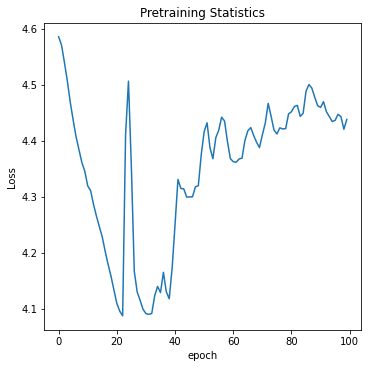

In [17]:
plt.figure(figsize=(5,5), constrained_layout=True)
plt.title("Pretraining Statistics")
plt.plot([h['train_stats']['loss'] for h in history_fe])
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.show()

In [18]:
## Train a classification layer using the extracted feature of the model above
n_epochs = 200
batch_size = 32
learning_rate = 1e-1
momentum = 0.9
weight_decay = 5e-4

best_acc = -1
best_model_dict = {}
best_history_fc = []

for j, dict in enumerate(models):
    model.load_state_dict(dict)
    optimizer_fc = torch.optim.SGD(model.fc.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay, nesterov=True)
    lr_scheduler_fc = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_fc, T_max=n_epochs)
    dataloader_fc = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
    dataloader_val = torch.utils.data.DataLoader(test_ds, batch_size=64)
    criterion_fc = nn.CrossEntropyLoss()

    history_fc = []

    for i in range(n_epochs):
        train_stats = train_one_epoch(model, optimizer_fc, criterion_fc, dataloader_fc)
        test_stats = evaluate(model, criterion_fc, dataloader_val)
        history_fc.append(
            {
            'train_stats': train_stats,
            'test_stats':test_stats
            }
        )
        lr_scheduler_fc.step()

    if test_stats['acc'] > best_acc:
        best_acc = test_stats['acc']
        best_model_dict = copy.deepcopy(model.state_dict())
        best_history_fc = copy.deepcopy(history_fc)
        print(str(j+1)+"/"+str(len(models))+" archieved "+str(best_acc)+" % Validation Accuracy, which has been trained for "+str(model_save_step*(j+1))+"epochs.")
    if best_acc == 100:
        break

1/3 archieved 99.0 % Validation Accuracy, which has been trained for 25epochs.


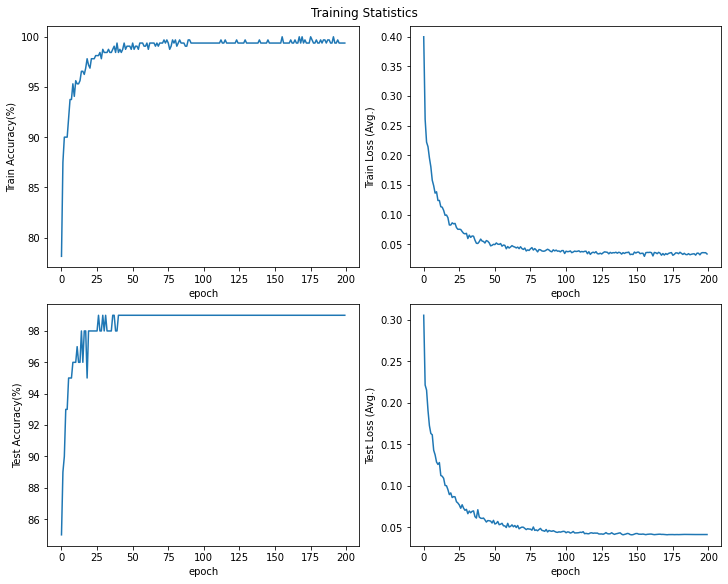

In [19]:
model.load_state_dict(best_model_dict)
history_fc = best_history_fc

fig, ax = plt.subplots(2,2, figsize=(10,8), constrained_layout=True)
fig.suptitle('Training Statistics')
ax[0][0].plot([h['train_stats']['acc'] for h in history_fc])
ax[0][0].set_xlabel('epoch')
ax[0][0].set_ylabel('Train Accuracy(%)')
ax[0][1].plot([h['train_stats']['loss'] for h in history_fc])
ax[0][1].set_xlabel('epoch')
ax[0][1].set_ylabel('Train Loss (Avg.)')

ax[1][0].plot([h['test_stats']['acc'] for h in history_fc])
ax[1][0].set_xlabel('epoch')
ax[1][0].set_ylabel('Test Accuracy(%)')
ax[1][1].plot([h['test_stats']['loss'] for h in history_fc])
ax[1][1].set_xlabel('epoch')
ax[1][1].set_ylabel('Test Loss (Avg.)')
plt.show()

In [20]:
## Comparison to basic NN Fully supervised training
n_epochs = 200
batch_size = 32
learning_rate = 1e-1
momentum = 0.9
weight_decay = 5e-4

baseline = Net(num_classes=n_classes, feature_dim=feature_dim, projection_dim=projection_dim)
supervised_optimizer = torch.optim.SGD(baseline.fc.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay, nesterov=True)
supervised_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(supervised_optimizer, T_max=n_epochs)
supervised_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
dataloader_val = torch.utils.data.DataLoader(test_ds, batch_size=64)
criterion = nn.CrossEntropyLoss()

history = []

for i in tqdm(range(n_epochs)):
    train_stats = train_one_epoch(model=baseline, supervised_loader=supervised_dataloader, criterion=criterion, optimizer=supervised_optimizer, device='cuda')
    test_stats = evaluate(model=baseline, test_loader=dataloader_val, criterion=criterion, device='cuda')
    history.append(
        {
        'train_stats': train_stats,
        'test_stats':test_stats
        }
    )
    supervised_lr_scheduler.step()
print("Test-Accuracy:",history[-1]['test_stats']['acc'])

  0%|          | 0/200 [00:00<?, ?it/s]

Test-Accuracy: 99.0


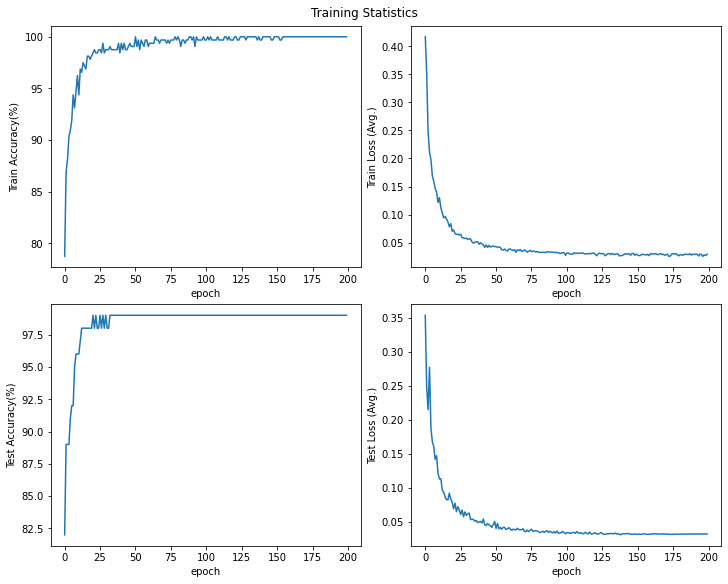

In [21]:
fig, ax = plt.subplots(2,2, figsize=(10,8), constrained_layout=True)
fig.suptitle('Training Statistics')
ax[0][0].plot([h['train_stats']['acc'] for h in history])
ax[0][0].set_xlabel('epoch')
ax[0][0].set_ylabel('Train Accuracy(%)')
ax[0][1].plot([h['train_stats']['loss'] for h in history])
ax[0][1].set_xlabel('epoch')
ax[0][1].set_ylabel('Train Loss (Avg.)')

ax[1][0].plot([h['test_stats']['acc'] for h in history])
ax[1][0].set_xlabel('epoch')
ax[1][0].set_ylabel('Test Accuracy(%)')
ax[1][1].plot([h['test_stats']['loss'] for h in history])
ax[1][1].set_xlabel('epoch')
ax[1][1].set_ylabel('Test Loss (Avg.)')
plt.show()

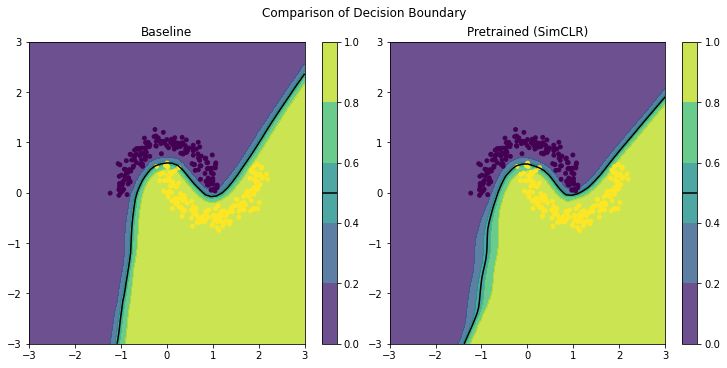

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
fig.suptitle("Comparison of Decision Boundary")
plot_contour(baseline, train_ds.tensors[0], train_ds.tensors[1], ax[0])
ax[0].set_title("Baseline")
plot_contour(model, train_ds.tensors[0], train_ds.tensors[1], ax[1])
ax[1].set_title("Pretrained (SimCLR)")
plt.show()

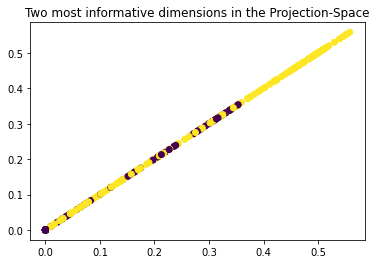

In [23]:
# Forward pass the data through the model and get the projections
proj = model(train_ds.tensors[0], get_projections=True).detach()

# Find the dimensions of the projections with the most highest variance
proj_var = torch.var(proj, dim=0)
topk_var_idx = torch.topk(proj_var, k=2)[1]

# Plot the projections of the highest variance
plt.figure()
plt.title("Two most informative dimensions in the Projection-Space")
plt.scatter(proj[:,topk_var_idx[0]], proj[:,topk_var_idx[0]], c=train_ds.tensors[1])
plt.show()

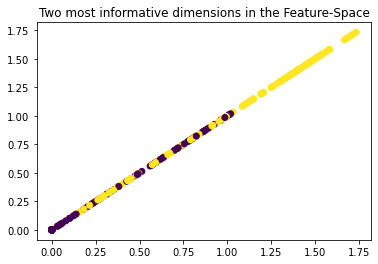

In [24]:
# Forward pass the data through the model and get the features
feat = model(train_ds.tensors[0], get_features=True).detach()

# Find the dimensions of the features with the most highest variance
feat_var = torch.var(feat, dim=0)
topk_var_idx = torch.topk(feat_var, k=2)[1]

# Plot the two dimensions of features with the highest variance
plt.figure()
plt.title("Two most informative dimensions in the Feature-Space")
plt.scatter(feat[:,topk_var_idx[0]], feat[:,topk_var_idx[0]], c=train_ds.tensors[1])
plt.show()

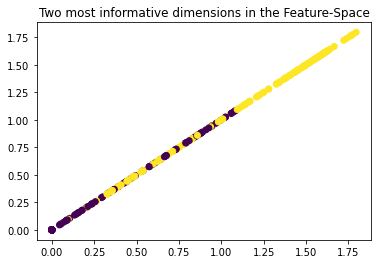

In [25]:
# Compare that to baseline
feat = baseline(train_ds.tensors[0], get_features=True).detach()

# Find the dimensions of the features with the most highest variance
feat_var = torch.var(feat, dim=0)
topk_var_idx = torch.topk(feat_var, k=2)[1]

# Plot the two dimensions of features with the highest variance
plt.figure()
plt.title("Two most informative dimensions in the Feature-Space")
plt.scatter(feat[:,topk_var_idx[0]], feat[:,topk_var_idx[0]], c=train_ds.tensors[1])
plt.show()